In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm
import torch
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions import Normal

class TorchGaussianSyntheticClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean', 'std', and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        self.n_features_ = 1
        self.n_classes_ = 3
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((len(X), len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = self.class_params[int(c)]["mean"]
            std = self.class_params[int(c)]["std"]
            prior = self.class_params[int(c)]["prior"]
            
            # Calculate Gaussian PDF: P(x|y=c)
            normal_dist = Normal(loc=mean, scale=std)
            px_given_y = torch.exp(normal_dist.log_prob(X))
            
            # Combine with prior: P(x|y=c) * P(y=c)
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples,)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]

    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples,)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            # Sample feature value from the corresponding Gaussian
            mean = self.class_params[int(self.classes_[sampled_class])]["mean"]
            std = self.class_params[int(self.classes_[sampled_class])]["std"]
            normal_dist = Normal(loc=mean, scale=std)
            sampled_x = normal_dist.sample().item()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.tensor(X, device=self.device), torch.tensor(y, device=self.device)



In [21]:
from torchcp.classification.score import APS, THR
aps = APS(score_type="identity", randomized=False)
lac = THR(score_type="identity",)
score = aps

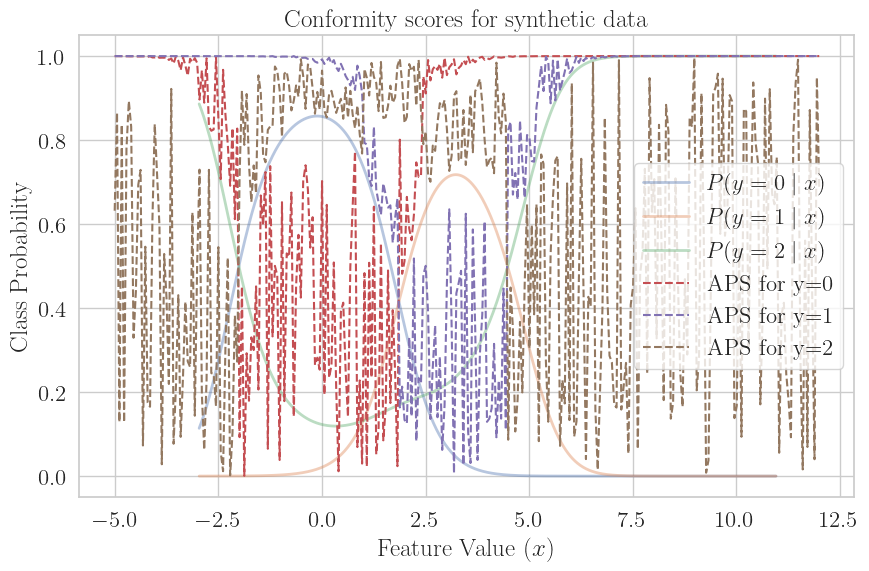

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 2)

# Step 1: Define class parameters
class_params = {
    0: {"mean": 1, "std": 1, "prior": 0.3},
    1: {"mean": 3, "std": 1, "prior": 0.4},
    2: {"mean": 4, "std": 2.2, "prior": 0.3},
}   

# Create an instance of the Torch-based classifier
clf = TorchGaussianSyntheticClassifier(class_params=class_params, device="cpu")

# Generate synthetic data
X, y = clf.generate_data(n_samples=1000)

# Step 4: Fit the classifier (it's effectively a no-op, but we call it for sklearn compatibility)
clf.fit(X, y)

# Step 5: Predict probabilities for a range of x values (for plotting)
x_range = torch.linspace(X.min() - 1, X.max() + 1, 1000)
probs = clf.predict_proba(x_range)

# Step 6: Plot the data and probabilities
plt.figure(figsize=(10, 6))

# Scatter plot of the synthetic data
# plt.scatter(X, y + np.random.uniform(-0.1, 0.1, len(y)), c=y, cmap='viridis', alpha=0.6, edgecolor='k', label='Data')

# Plot the probabilities for each class
for i, c in enumerate(clf.classes_):
    plt.plot(x_range, probs[:, i], label=rf'$P(y={c} \mid x)$', linewidth=2, alpha=0.4)

X_nc = torch.linspace(-5,12,300)
y_0  = torch.full(size=(300,),fill_value=0)
y_1  = torch.full(size=(300,),fill_value=1)
y_2  = torch.full(size=(300,),fill_value=2)


y_0_nc = score(clf.predict_proba(X_nc),y_0).detach().cpu().numpy()
y_1_nc = score(clf.predict_proba(X_nc),y_1).detach().cpu().numpy()
y_2_nc = score(clf.predict_proba(X_nc),y_2).detach().cpu().numpy()


plt.plot(X_nc.flatten(), y_0_nc, linestyle="--", label="APS for y=0")
plt.plot(X_nc.flatten(), y_1_nc, linestyle="--", label="APS for y=1")
plt.plot(X_nc.flatten(), y_2_nc, linestyle="--", label="APS for y=2")


# Labels and title
plt.title("Conformity scores for synthetic data")
plt.xlabel("Feature Value ($x$)")
plt.ylabel("Class Probability")
plt.legend()
plt.show()